## Introduction

The purpose of this project is to explore insights from a company's delivery data. The data contains information on the company's orders, including the warehouses from where they were ordered, the order date, delivery date, customer code, and customer Zip codes. The analysis is primarily done using the Python pandas module.

The analysis aims to nswer the following questions;

- Which Zip code has the most orders?
- What was the ratio of one-time customers to returning customers?
- What is the distribution of order times? (When are customers likley to make orders?)
- What was the average delivery time for one-time customers versus returning customers?
- What was the average deliery time across Zip codes and in each month?
- Which warehouse had the most orders in each Zip code?
- Did orders increase or decrease each month across Zip codes?
- Which season had the fastest deliveries?
- Which warehouse had the fastest deliveries?

### Importing Relevant Libraries and the Dataset

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pgeocode
from shapely.geometry import Point

In [2]:
df = pd.read_excel("Delivery_dataset.xlsx")
df.head()

,S/N,Warehouse,Order date,Delivery date,Customer,Zipcode
0,1,Butler,2021-01-03 13:44:00,2021-01-03 18:39:00,8240,15317
1,2,McKees Rocks,2021-01-04 06:26:00,2021-01-04 15:28:00,484,15102
2,3,Butler,2021-01-04 06:29:00,2021-01-04 19:29:00,13512,15301
3,4,Butler,2021-01-04 07:31:00,2021-01-04 15:59:00,11326,15228
4,5,Butler,2021-01-04 19:12:00,2021-02-04 16:10:00,13306,15301


In [3]:
df.tail()

,S/N,Warehouse,Order date,Delivery date,Customer,Zipcode
9475,9476,Pittsburgh Mills,9/30/2022 9:05,2022-03-10 17:45:00,220585,15106
9476,9477,Butler,9/30/2022 9:13,2022-05-10 17:13:00,17418,15209
9477,9478,Washington Big Box,9/30/2022 9:13,2022-03-10 18:14:00,270991,15216
9478,9479,Washington,9/30/2022 9:15,2022-03-10 18:32:00,270991,15216
9479,9480,Butler,9/30/2022 9:19,2022-04-10 16:09:00,100906,15237


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9480 entries, 0 to 9479
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   S/N            9480 non-null   int64 
 1   Warehouse      9480 non-null   object
 2   Order date     9480 non-null   object
 3   Delivery date  9480 non-null   object
 4   Customer       9480 non-null   object
 5   Zipcode        9480 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 444.5+ KB


## Data Cleaning

### Data Types

Checking if the columns have consistent data types

In [5]:
for column in df.columns:
    
    unique_data_types = df[column].apply(type).unique()
    
    if len(unique_data_types) > 1:
        print(f"Column '{column}' has more than one type of data.")
        print("Unique data types:", unique_data_types)
    else:
        print(f"Column '{column}' has the same data type:", unique_data_types[0])

Column 'S/N' has the same data type: <class 'int'>
Column 'Warehouse' has the same data type: <class 'str'>
Column 'Order date' has more than one type of data.
Unique data types: [<class 'datetime.datetime'> <class 'str'>]
Column 'Delivery date' has more than one type of data.
Unique data types: [<class 'datetime.datetime'> <class 'str'>]
Column 'Customer' has more than one type of data.
Unique data types: [<class 'int'> <class 'str'>]
Column 'Zipcode' has the same data type: <class 'int'>


#### Findings

The S/N (serial number), Warehouse, and Zip Code columns have the same data types.

The Order date, Delivery Date, and Customer columns have more than one datatypes; hence, need cleaning.

In the following cells, I will make the following changes;

- Order date changed to consistently be datetime datatype
- Delivery date changed to consistently be datetime datatype
- Customer data type changed to be an int data type
- Zip code also changed to a string

In [6]:
#Order date and delivery date changes

df['Order date'] = pd.to_datetime(df['Order date'])
df['Delivery date'] = pd.to_datetime(df['Delivery date'])
df['Customer'] = df['Customer'].astype(str)
df['Zipcode'] = df['Zipcode'].astype(str)


In [7]:
#rerunning this to confirm changes

for column in df.columns:
    
    unique_data_types = df[column].apply(type).unique()
    
    if len(unique_data_types) > 1:
        print(f"Column '{column}' has more than one type of data.")
        print("Unique data types:", unique_data_types)
    else:
        print(f"Column '{column}' has the same data type:", unique_data_types[0])

Column 'S/N' has the same data type: <class 'int'>
Column 'Warehouse' has the same data type: <class 'str'>
Column 'Order date' has the same data type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Column 'Delivery date' has the same data type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Column 'Customer' has the same data type: <class 'str'>
Column 'Zipcode' has the same data type: <class 'str'>


### Missing Data

The following code shows that none of the columns has missing data

In [8]:
print(df.isnull().sum())

S/N              0
Warehouse        0
Order date       0
Delivery date    0
Customer         0
Zipcode          0
dtype: int64


### Duplicates

Checking for possible duplicated data in the dataset

In [9]:
duplicated_data = df.duplicated()

num_duplicated = duplicated_data.sum()

print(num_duplicated)

0


There are no complete duplicates, but there is a possibility of half duplicates. If the Order date, Delivery date, and Customer code are exactly the same, then there is a likelihood that the data is duplicated. Thus, the following code checks for duplicated data with a subset of these three columns.

In [10]:
half_duplicates = df.duplicated(subset=['Order date', 'Delivery date', 'Customer'], keep=False)
print(half_duplicates.sum())

264


In [11]:
duplicates_df = df[half_duplicates]

duplicates_df

,S/N,Warehouse,Order date,Delivery date,Customer,Zipcode
14,15,Washington,2021-01-06 21:35:00,2021-02-06 16:44:00,2956,15241
15,16,McKees Rocks,2021-01-06 21:35:00,2021-02-06 16:44:00,2956,15241
58,59,Butler,2021-01-12 14:06:00,2021-03-12 15:57:00,11396,15220
59,60,Beaver,2021-01-12 14:06:00,2021-03-12 15:57:00,11396,15220
82,83,McKees Rocks,2021-02-08 13:12:00,2021-03-08 16:57:00,16332,15317
...,...,...,...,...,...,...
9169,9170,Washington,2021-09-23 20:01:00,2021-09-29 16:35:00,7679,15044
9320,9321,Pittsburgh Mills,2022-09-27 08:48:00,2022-09-29 10:13:00,119778,15214
9321,9322,Washington,2022-09-27 08:48:00,2022-09-29 10:13:00,119778,15214
9442,9443,Beaver,2021-09-30 18:12:00,2021-04-10 14:14:00,11132,15220


Based on the above data of duplicates, there is a likelihood that the duplicated data represents the same orders recorded in different warehouses. Since this analysis focuses on each customer order, I will drop the duplicates.

In [12]:
#dropping duplicates and checking if change is successful

df.drop_duplicates(subset=['Order date', 'Delivery date', 'Customer'], inplace=True)

half_duplicates = df.duplicated(subset=['Order date', 'Delivery date', 'Customer'])
print(half_duplicates.sum())

0


## Data Analysis

### Zip Code with the most Orders

In [13]:
df['Zipcode'].unique()

array(['15317', '15102', '15301', '15228', '15218', '15044', '15236',
       '15017', '15241', '15367', '15216', '15220', '15237', '15221',
       '15227', '15222', '15057', '15106', '15129', '15206', '15205',
       '15211', '15233', '15212', '15235', '15213', '15090', '15226',
       '15120', '15234', '15207', '15243', '15210', '15055', '15201',
       '15217', '15224', '15203', '15321', '15143', '15209', '15223',
       '15144', '15232', '15007', '44223', '15112', '15202', '15208',
       '15332', '15214', '15342', '15084', '16001', '15136', '15010',
       '44485', '44512', '44320', '15238', '44321', '15101', '16066',
       '15116', '15219', '15147', '15204', '44442', '15122', '15146',
       '44312', '44515', '44484', '15071', '15330', '15031', '15108',
       '44514', '15239', '15215', '16046', '15229', '29680', '44505',
       '16002', '44420', '15068', '44511', '16101', '15145', '15063',
       '26501', '15035', '44509', '44266', '44446', '44471'], dtype=object)

In [14]:
zip_counts = df['Zipcode'].value_counts()

print(zip_counts)

15241    895
15317    805
15237    551
15220    501
15102    420
        ... 
15031      1
44505      1
29680      1
44320      1
44471      1
Name: Zipcode, Length: 97, dtype: int64


The Zip code with the most orders is 15241 with 895 orders. It is followed closely by 15317 with 805 orders and the third is 15237 with 551 orders. 

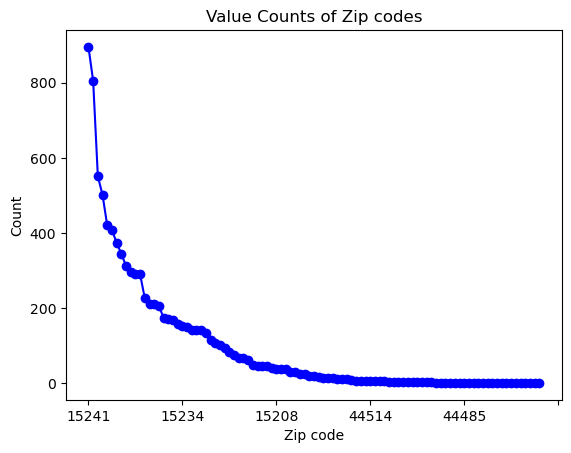

In [15]:

# Plot the zip code counts in a line chart
zip_counts.plot(kind='line', marker='o', linestyle='-', color='b')

# Set plot labels and title
plt.xlabel('Zip code')
plt.ylabel('Count')
plt.title('Value Counts of Zip codes')

# Show the plot
plt.show()

A plot of the distribution of zip codes shows that most orders come from Zip codes starting with 1. Zip codes starting with 1 tend to be in Delaware, New York, Pennsylvania. Fewest orders come from places with Zip codes starting with 4, which tends to be in Indiana, Kentucky, Michigan, Ohio. I will try to visualize the company's orders by location to identify where most orders come from.

In [16]:
"""The code in this cell creates a geoDataFrame that includes the zip codes, 
and latitudes and longitudes representing each zip. This allows the use of geopandas to map the data"""

zip_df = pd.DataFrame(df['Zipcode'])

#Initialize the Nominatim object
nomi = pgeocode.Nominatim('us')

# Apply the query_postal_code function to each zip code
zip_df['lat'] = zip_df['Zipcode'].apply(lambda x: nomi.query_postal_code(x).latitude)
zip_df['long'] = zip_df['Zipcode'].apply(lambda x: nomi.query_postal_code(x).longitude)

# Display the resulting DataFrame
print(zip_df.head())

  Zipcode      lat     long
0   15317  40.2706 -80.1668
1   15102  40.3210 -80.0398
2   15301  40.1717 -80.2560
3   15228  40.3696 -80.0439
4   15301  40.1717 -80.2560


In [17]:
#merge the value counts data frame and the zip geoDataFrame

merged_df = zip_df.merge(df, on='Zipcode', how='inner')


In [18]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3468832 entries, 0 to 3468831
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Zipcode        object        
 1   lat            float64       
 2   long           float64       
 3   S/N            int64         
 4   Warehouse      object        
 5   Order date     datetime64[ns]
 6   Delivery date  datetime64[ns]
 7   Customer       object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 238.2+ MB


In [19]:
#Due to the inner join, there is a lot of duplicated data

print(merged_df.duplicated().sum())

3459486


In [20]:
#Created a new 'merge' df without duplicates 
merge = merged_df.drop_duplicates()
merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9346 entries, 0 to 3468831
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Zipcode        9346 non-null   object        
 1   lat            9346 non-null   float64       
 2   long           9346 non-null   float64       
 3   S/N            9346 non-null   int64         
 4   Warehouse      9346 non-null   object        
 5   Order date     9346 non-null   datetime64[ns]
 6   Delivery date  9346 non-null   datetime64[ns]
 7   Customer       9346 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 657.1+ KB


In [21]:
merge.head()

,Zipcode,lat,long,S/N,Warehouse,Order date,Delivery date,Customer
0,15317,40.2706,-80.1668,1,Butler,2021-01-03 13:44:00,2021-01-03 18:39:00,8240
1,15317,40.2706,-80.1668,9,McKees Rocks,2021-01-06 07:55:00,2021-01-06 12:52:00,8240
2,15317,40.2706,-80.1668,25,Washington,2021-01-09 07:31:00,2021-02-09 20:03:00,2223
3,15317,40.2706,-80.1668,29,Beaver,2021-01-09 21:13:00,2021-03-09 17:25:00,8240
4,15317,40.2706,-80.1668,46,Beaver,2021-01-11 19:14:00,2021-03-11 15:49:00,11565


In [30]:
geometry = [Point(lon, lat) for lon, lat in zip(merge['long'], merge['lat'])]
geo_df = gpd.GeoDataFrame(merge, geometry=geometry, crs="EPSG:4326")

# Print the GeoDataFrame
print(geo_df.head())

  Zipcode      lat     long  S/N     Warehouse          Order date  \
0   15317  40.2706 -80.1668    1        Butler 2021-01-03 13:44:00   
1   15317  40.2706 -80.1668    9  McKees Rocks 2021-01-06 07:55:00   
2   15317  40.2706 -80.1668   25    Washington 2021-01-09 07:31:00   
3   15317  40.2706 -80.1668   29        Beaver 2021-01-09 21:13:00   
4   15317  40.2706 -80.1668   46        Beaver 2021-01-11 19:14:00   

        Delivery date Customer                    geometry  
0 2021-01-03 18:39:00     8240  POINT (-80.16680 40.27060)  
1 2021-01-06 12:52:00     8240  POINT (-80.16680 40.27060)  
2 2021-02-09 20:03:00     2223  POINT (-80.16680 40.27060)  
3 2021-03-09 17:25:00     8240  POINT (-80.16680 40.27060)  
4 2021-03-11 15:49:00    11565  POINT (-80.16680 40.27060)  


C:\Users\user\AppData\Local\Temp\ipykernel_8816\934557980.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  usa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


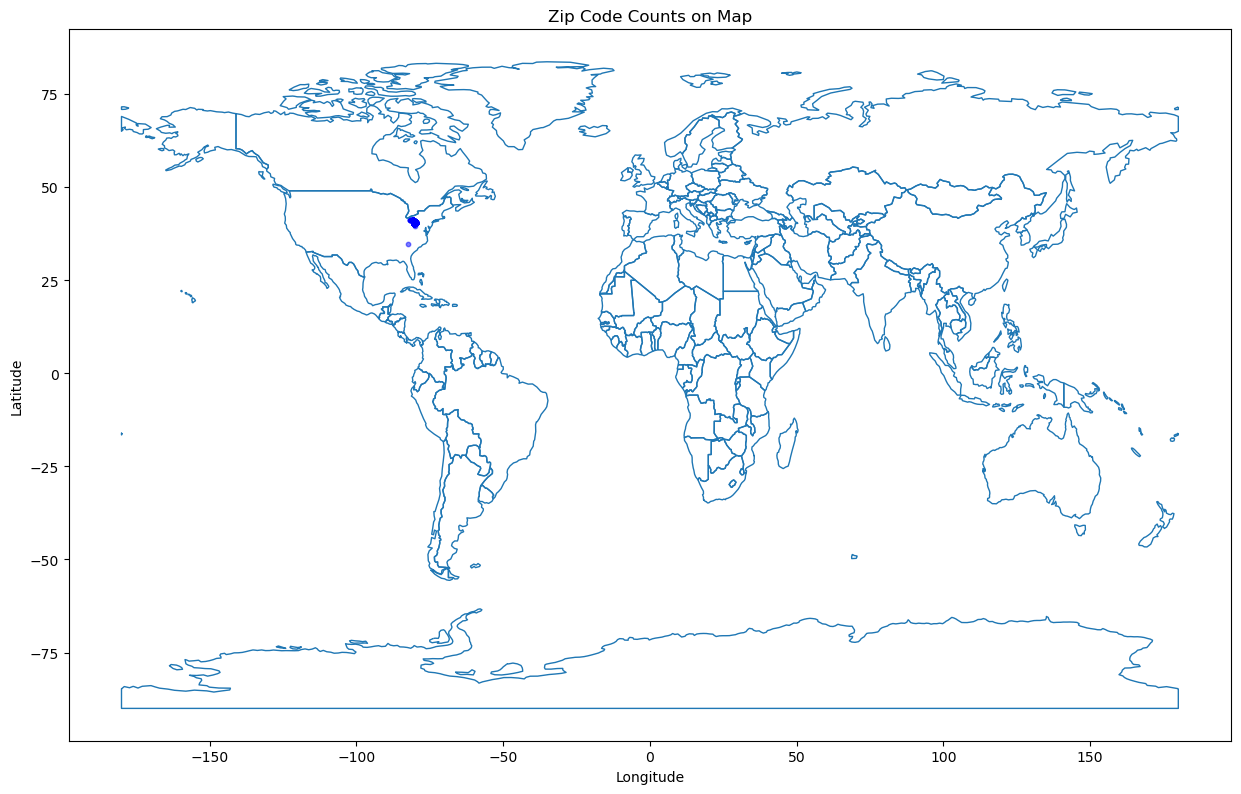

In [33]:
usa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plotting
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the map of the United States
usa.boundary.plot(ax=ax, linewidth=1)

# Plot your GeoDataFrame with zip code counts
geo_df.plot(marker='o', color='blue', markersize=10, alpha=0.5, ax=ax)

# Add labels and title
ax.set_title('Zip Code Counts on Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the map
plt.show()

### Ratio of one-time customers to returning customers